In [61]:
import pandas as pd

df=pd.read_excel("60 günlük veriler düzenlenmiş.xlsx")
df.head()
df["Datetime"] = pd.to_datetime(df["Analiz Tarihi"], dayfirst=True)

df = df.sort_values("Datetime").reset_index(drop=True)

df_raw = df.copy()

In [62]:
PARAMETERS = {
    "NaHCO3 (%)": {"LSL": 99.6, "USL": 99.9},
    "Na2CO3 (%)": {"LSL": 0.08, "USL": 0.15},
    "Cl- (mg/kg)": {"USL": 200},
    "SO42-(mg/kg)": {"USL": 300},
    "SÇM (mg/kg)": {"USL": 600},
    "Nem (%)": {"USL": 0.05},
    "Yığın Yoğunluğu (g/cm3)": {"LSL": 1.05, "USL": 1.25}
}


In [63]:
import numpy as np
df_imputed = df.copy()

PARAM_COLS = list(PARAMETERS.keys())

for col in PARAM_COLS:
    # ---- SPC LIMITLERİNİ HESAPLA (HAM VERİDEN) ----
    x = df[col].values
    MR = np.abs(np.diff(x))
    d2 = 1.128

    x_bar = np.nanmean(x)
    MR_bar = np.nanmean(MR)
    sigma = MR_bar / d2 if MR_bar > 0 else 0

    UCL = x_bar + 3 * sigma
    LCL = x_bar - 3 * sigma

    # ---- OUTLIER = NaN ----
    outlier_mask = (df_imputed[col] < LCL) | (df_imputed[col] > UCL)
    df_imputed.loc[outlier_mask, col] = np.nan

    # ---- ±3 GÜN LOKAL MEAN IMPUTATION ----
    for i in range(len(df_imputed)):
        if pd.isna(df_imputed.loc[i, col]):
            start = max(0, i - 3)
            end = min(len(df_imputed), i + 4)

            window_mean = df_imputed.loc[start:end, col].mean()
            df_imputed.loc[i, col] = window_mean
df_imputed = df_imputed.sort_values("Datetime").reset_index(drop=True)
df = df.sort_values("Datetime").reset_index(drop=True)


In [64]:
import numpy as np
import matplotlib.pyplot as plt

def draw_imr(df, value_col, title_suffix):
    # NaN'leri ayıkla
    x = df[value_col].dropna().values
    dates = df.loc[df[value_col].notna(), "Datetime"].values

    # Moving Range
    MR = np.abs(np.diff(x))

    d2 = 1.128
    x_bar = np.mean(x)
    MR_bar = np.mean(MR)
    sigma = MR_bar / d2 if MR_bar > 0 else 0

    # Limitler
    UCL_I = x_bar + 3 * sigma
    LCL_I = x_bar - 3 * sigma
    UCL_MR = 3.267 * MR_bar

    # =====================
    # I-CHART
    # =====================
    plt.figure(figsize=(14,4))
    plt.plot(dates, x, marker="o")
    plt.axhline(x_bar, linestyle="--", label="CL")
    plt.axhline(UCL_I, color="red", linestyle="--", label="UCL")
    plt.axhline(LCL_I, color="red", linestyle="--", label="LCL")
    plt.title(f"{value_col} – I-Chart ({title_suffix})")
    plt.ylabel(value_col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # =====================
    # MR-CHART
    # =====================
    plt.figure(figsize=(14,4))
    plt.plot(dates[1:], MR, marker="o")
    plt.axhline(MR_bar, linestyle="--", label="CL")
    plt.axhline(UCL_MR, color="red", linestyle="--", label="UCL")
    plt.title(f"{value_col} – MR-Chart ({title_suffix})")
    plt.ylabel("Moving Range")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "mean": x_bar,
        "sigma": sigma
    }


In [65]:
def cp_cpk(mean, sigma, LSL=None, USL=None):
    Cp = None
    Cpk = None

    if sigma == 0 or sigma is None:
        return Cp, Cpk

    if LSL is not None and USL is not None:
        Cp = (USL - LSL) / (6 * sigma)
        Cpk = min(
            (USL - mean) / (3 * sigma),
            (mean - LSL) / (3 * sigma)
        )
    elif USL is not None:
        Cp = (USL - mean) / (3 * sigma)
        Cpk = Cp
    elif LSL is not None:
        Cp = (mean - LSL) / (3 * sigma)
        Cpk = Cp

    return Cp, Cpk



PARAMETRE: NaHCO3 (%)


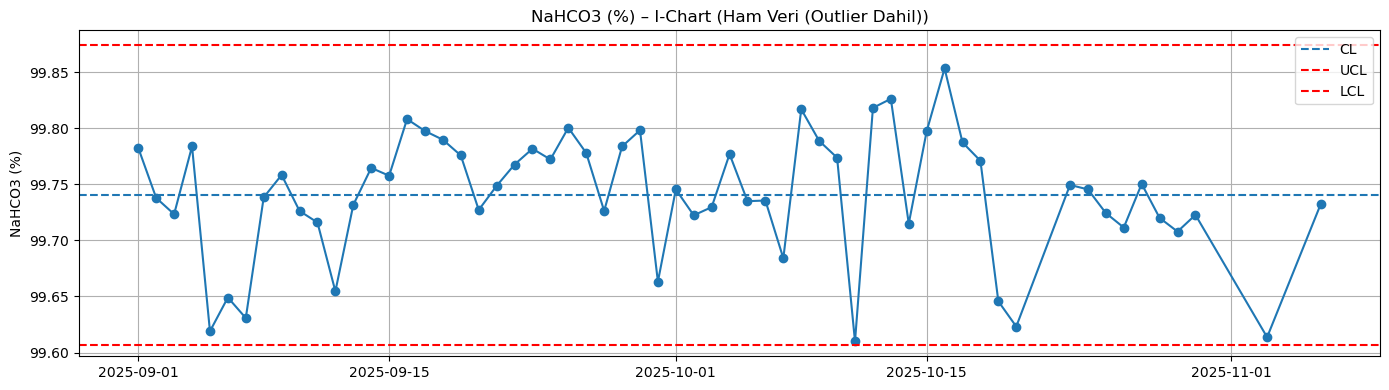

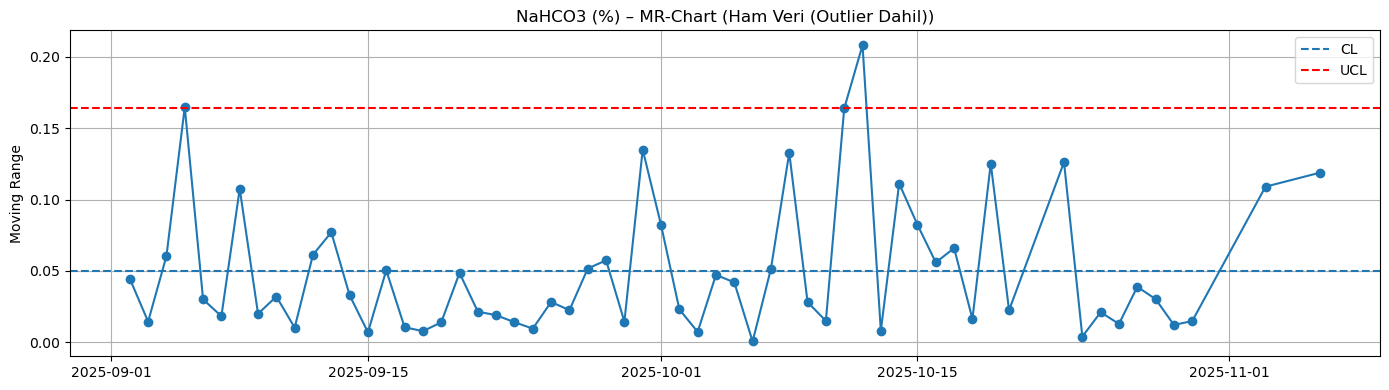

HAM → Mean: 99.7405 Sigma: 0.0446 Cp: 1.1219906939105901 Cpk: 1.0507318182839565


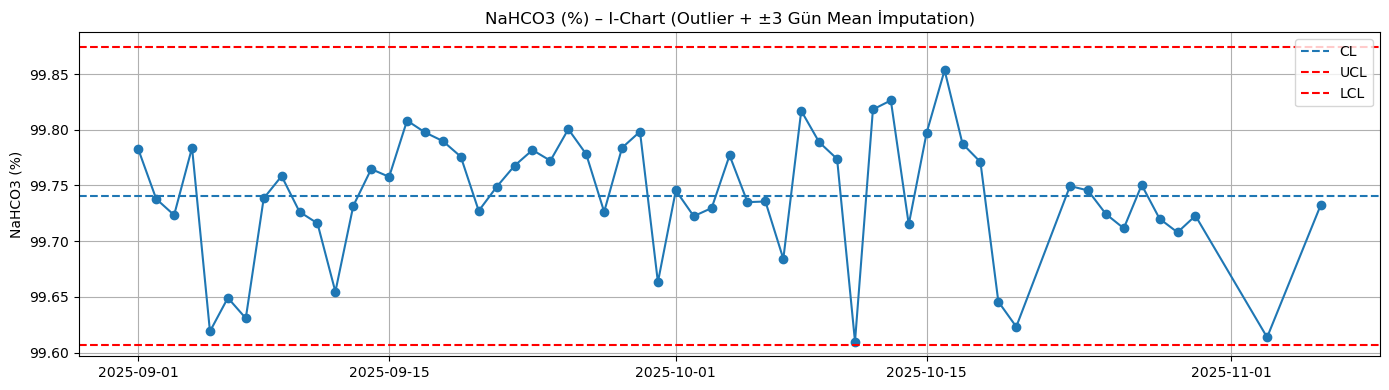

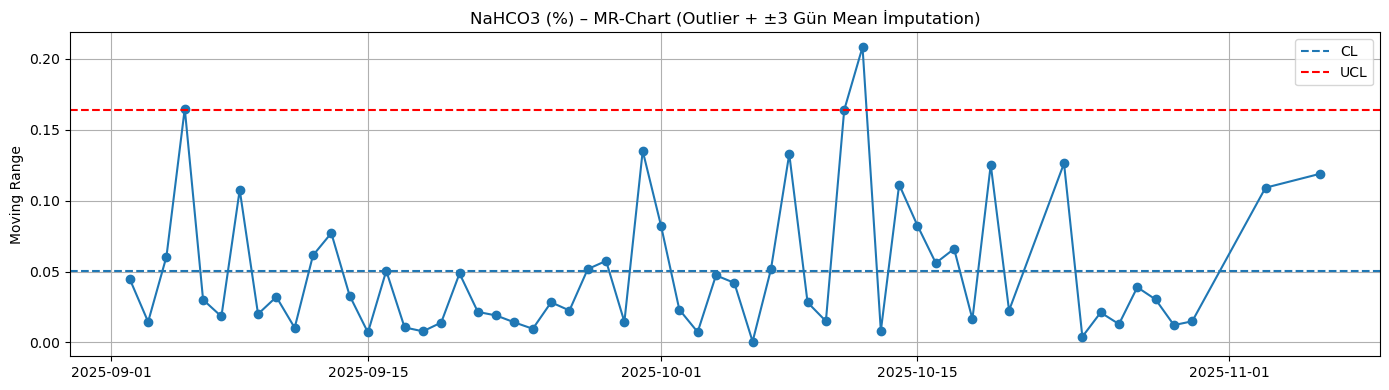

IMPUTE → Mean: 99.7405 Sigma: 0.0446 Cp: 1.1219906939105901 Cpk: 1.0507318182839565

PARAMETRE: Na2CO3 (%)


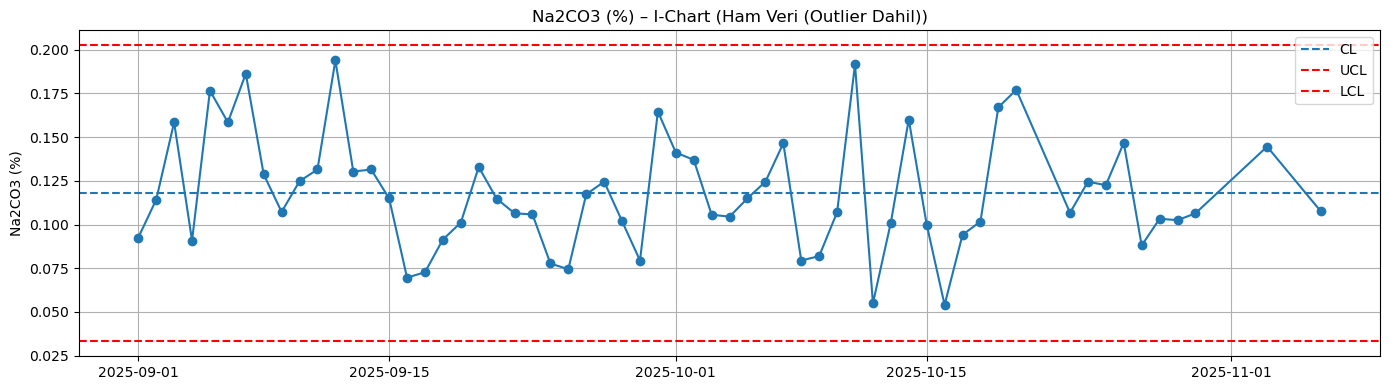

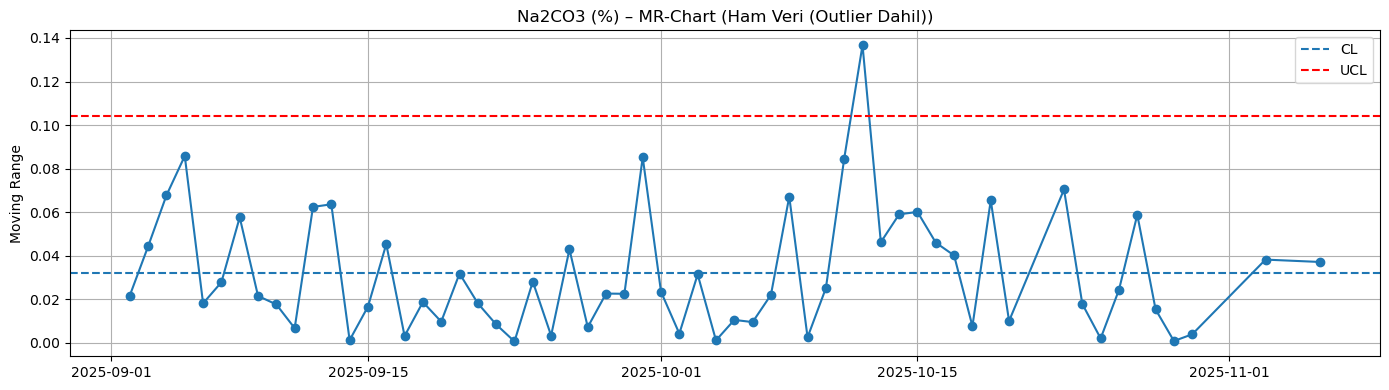

HAM → Mean: 0.1179 Sigma: 0.0283 Cp: 0.4127365511375717 Cpk: 0.3789707704302221


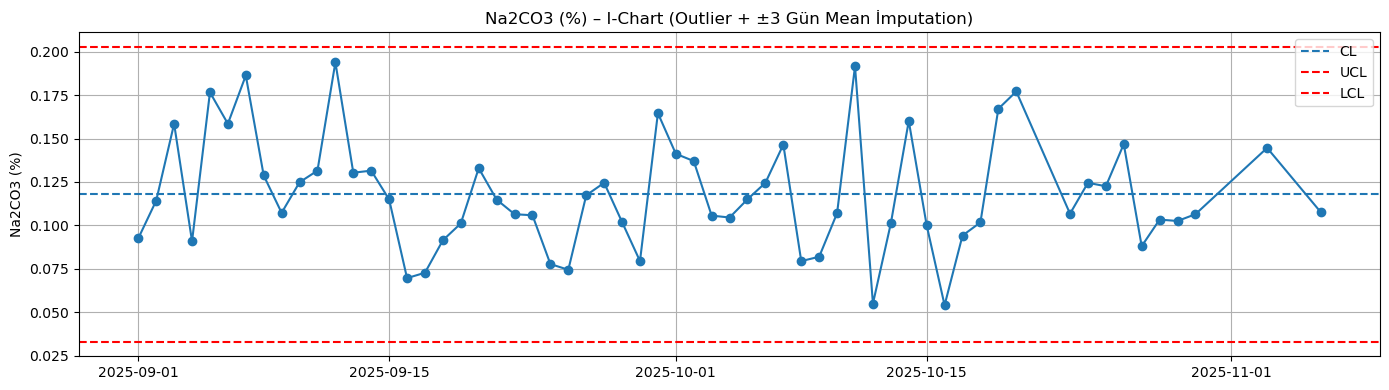

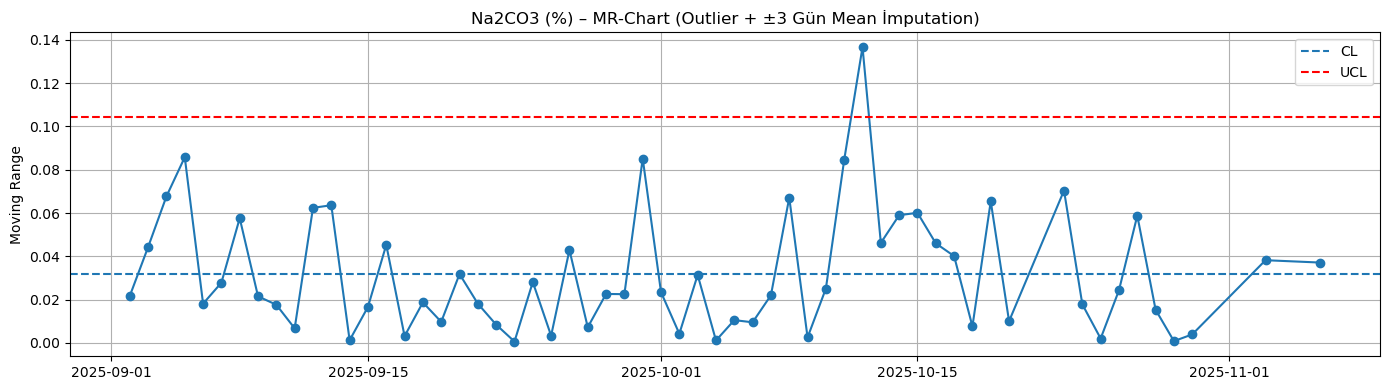

IMPUTE → Mean: 0.1179 Sigma: 0.0283 Cp: 0.4127365511375717 Cpk: 0.3789707704302221

PARAMETRE: Cl- (mg/kg)


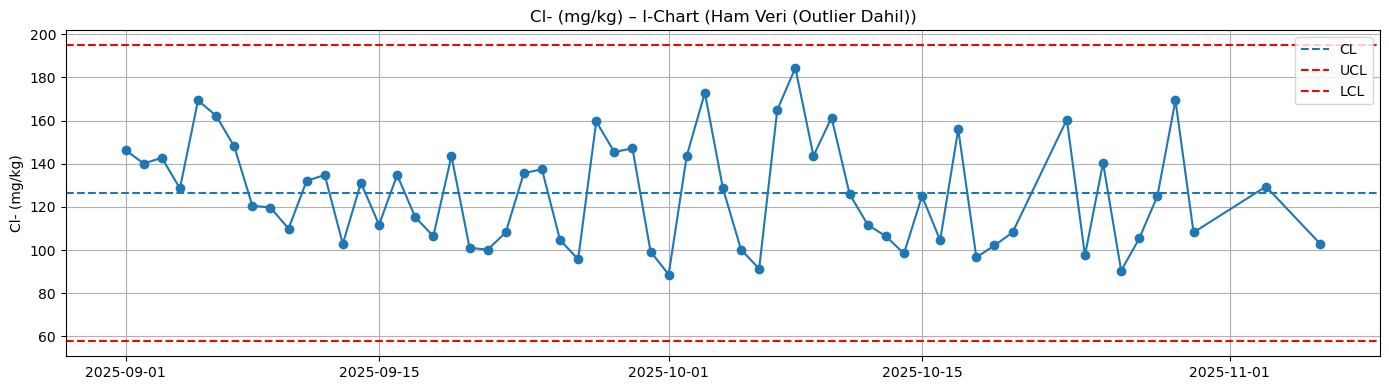

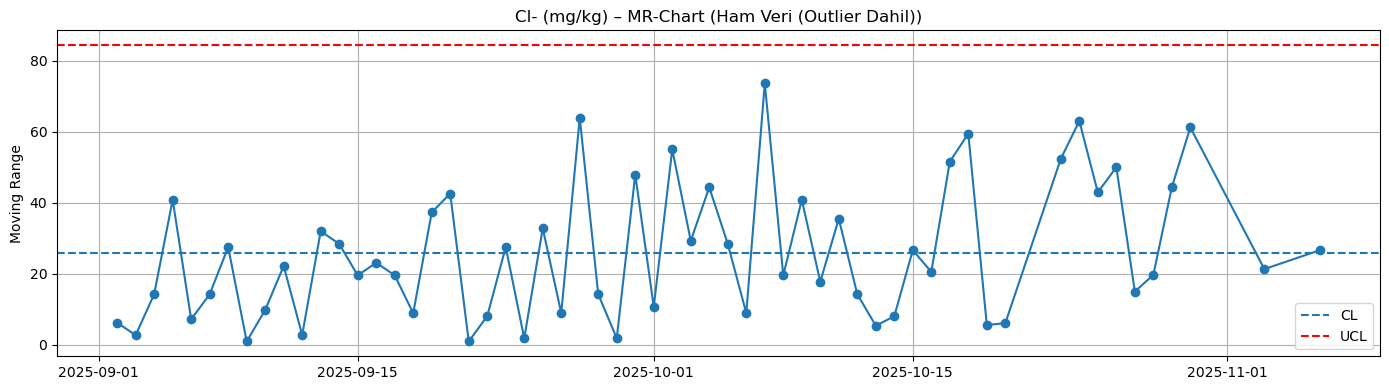

HAM → Mean: 126.3046 Sigma: 22.8899 Cp: 1.0731871538836517 Cpk: 1.0731871538836517


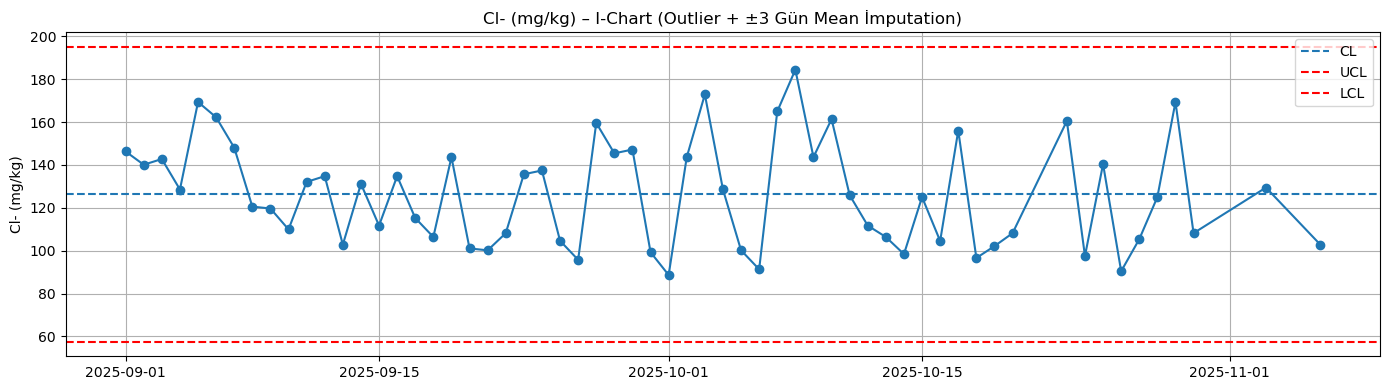

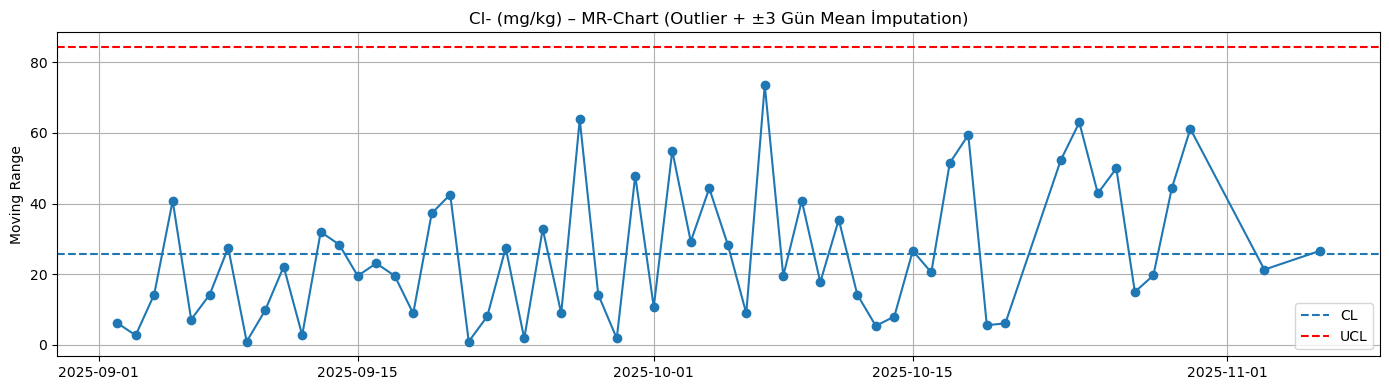

IMPUTE → Mean: 126.3046 Sigma: 22.8899 Cp: 1.0731871538836517 Cpk: 1.0731871538836517

PARAMETRE: SO42-(mg/kg)


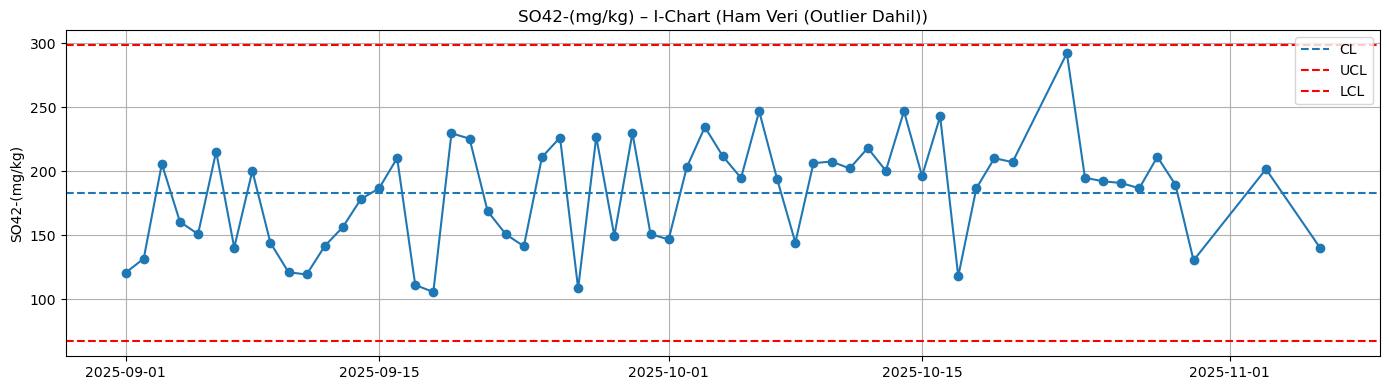

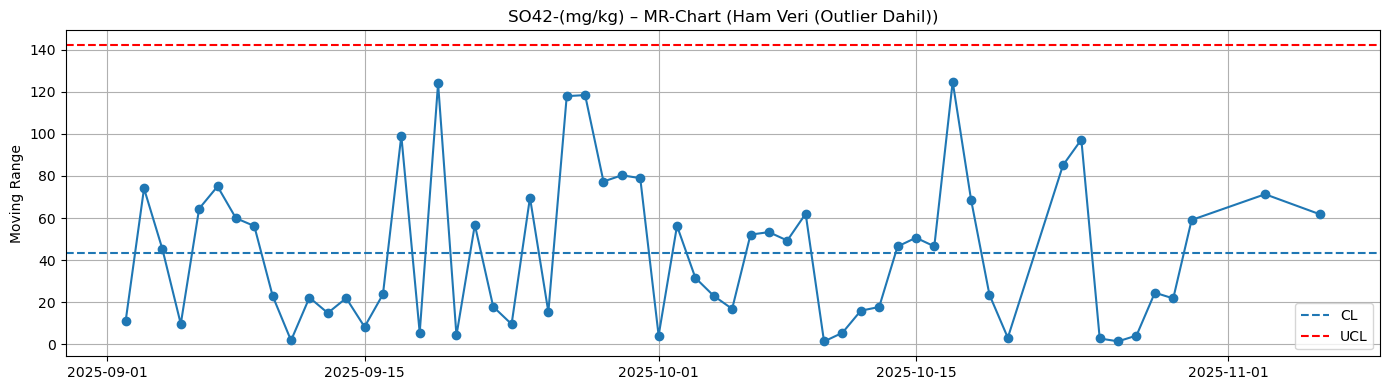

HAM → Mean: 182.7214 Sigma: 38.5873 Cp: 1.0131019926143776 Cpk: 1.0131019926143776


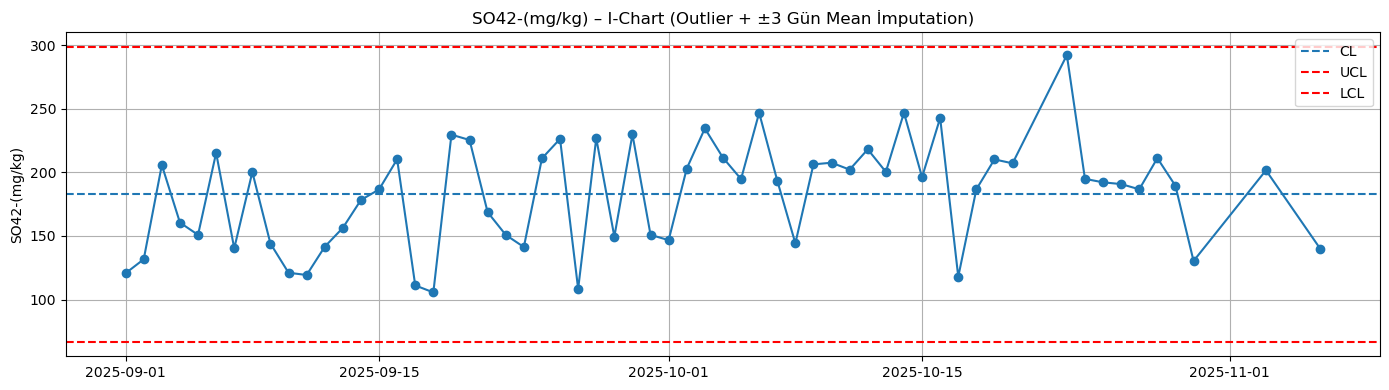

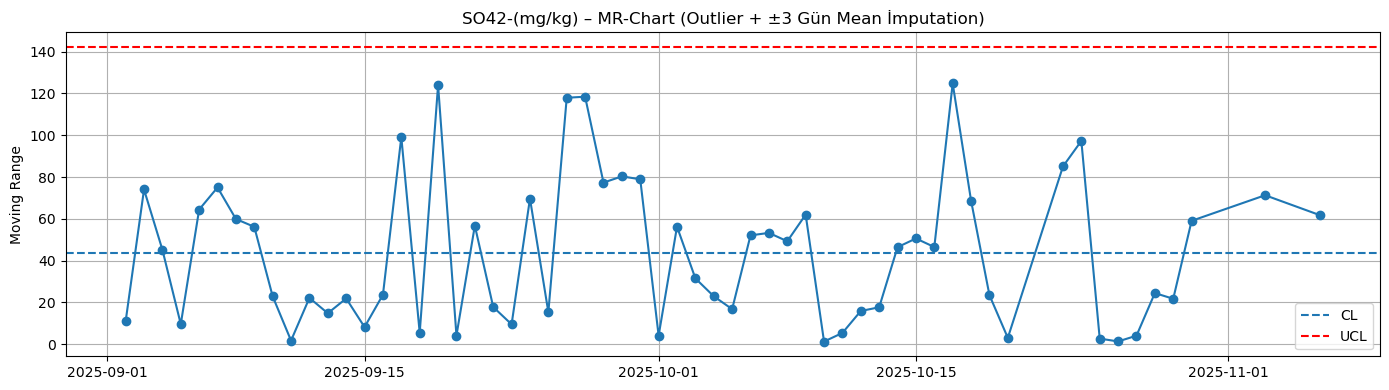

IMPUTE → Mean: 182.7214 Sigma: 38.5873 Cp: 1.0131019926143776 Cpk: 1.0131019926143776

PARAMETRE: SÇM (mg/kg)


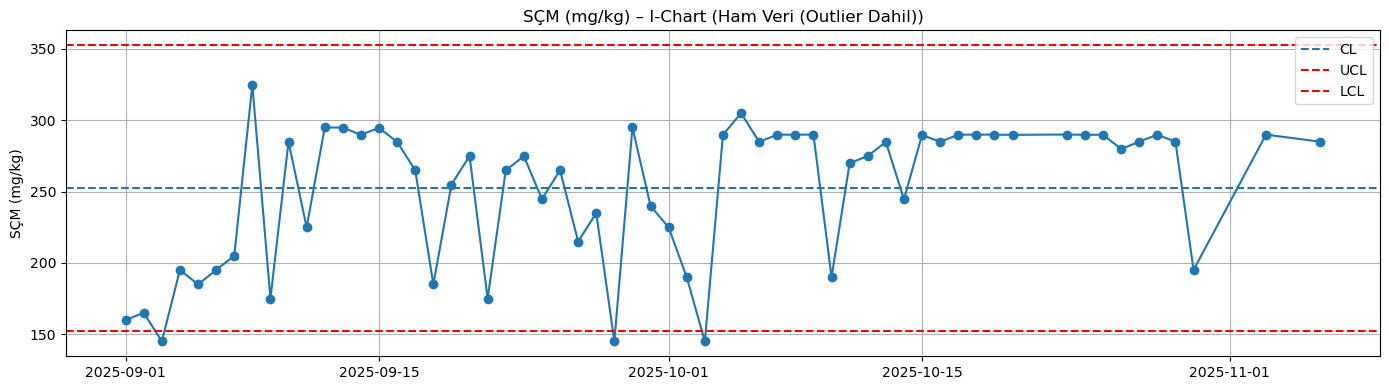

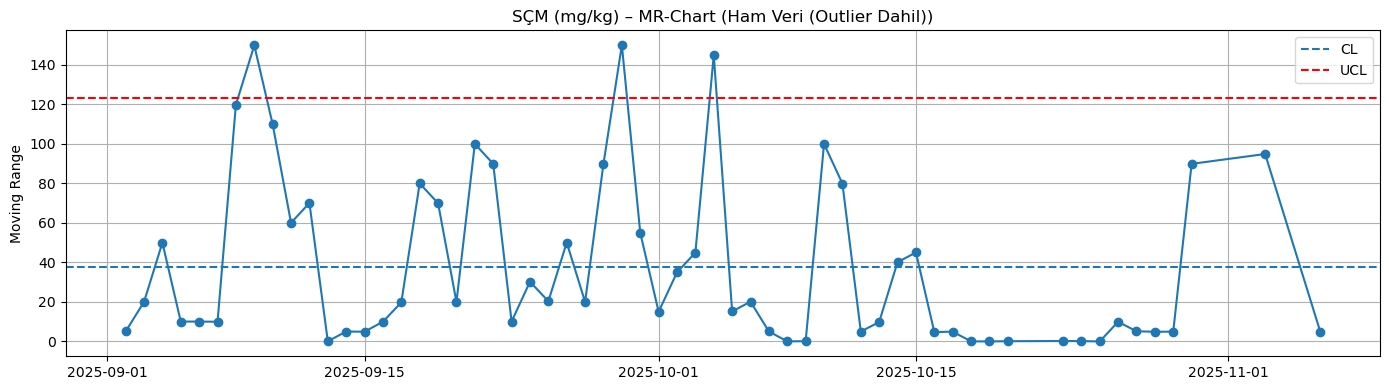

HAM → Mean: 252.3025 Sigma: 33.4574 Cp: 3.464084470759951 Cpk: 3.464084470759951


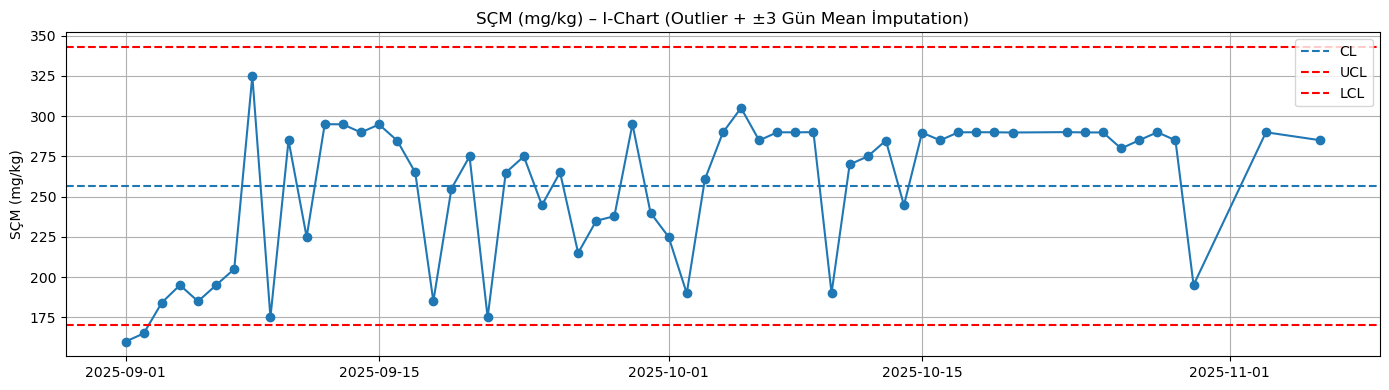

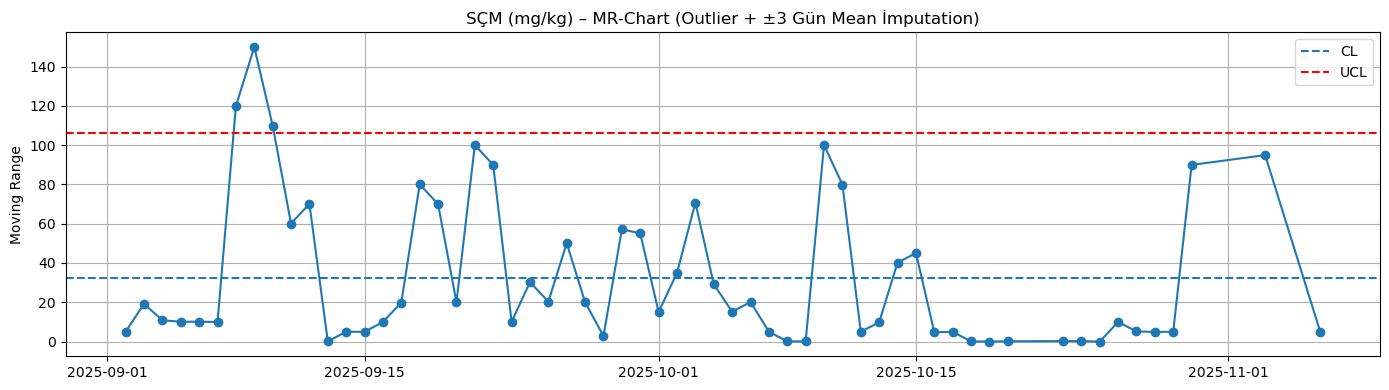

IMPUTE → Mean: 256.4319 Sigma: 28.7978 Cp: 3.9767817163630736 Cpk: 3.9767817163630736

PARAMETRE: Nem (%)


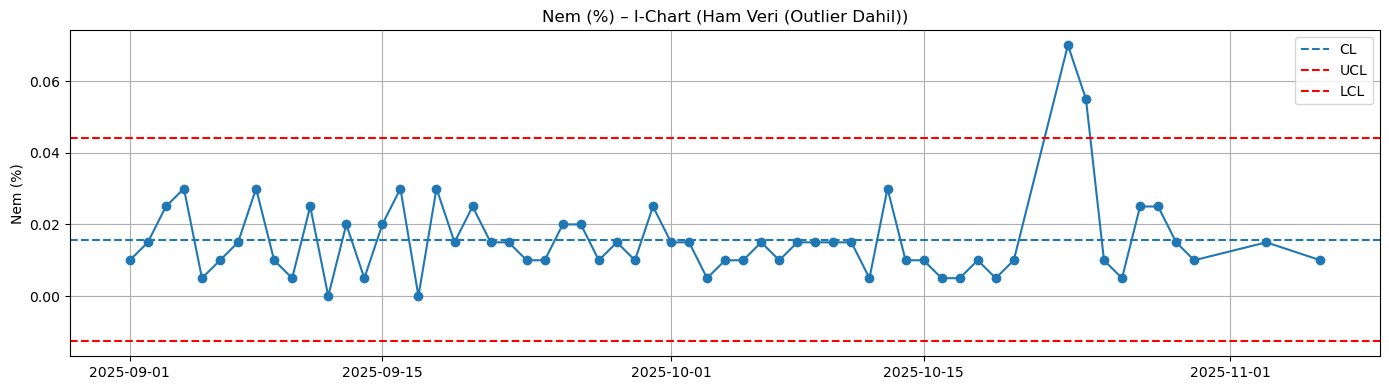

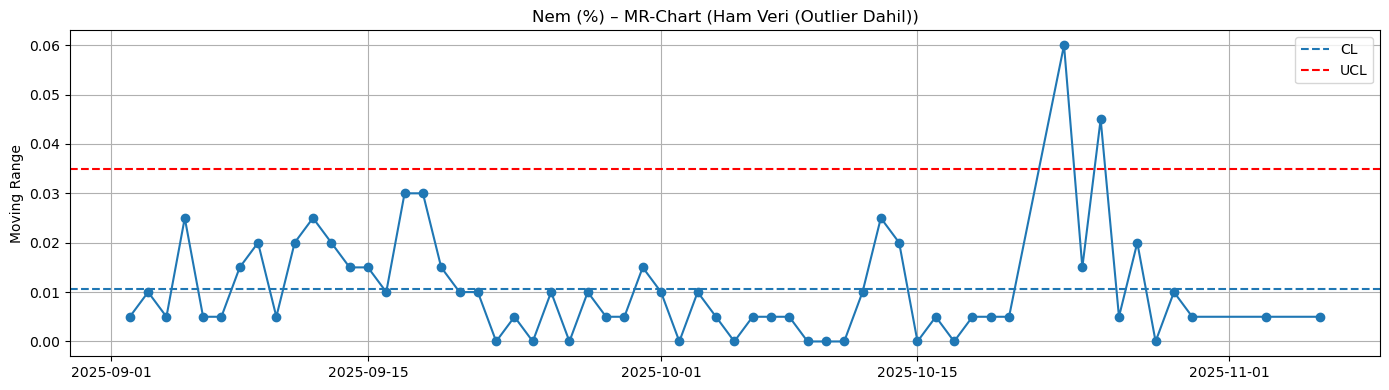

HAM → Mean: 0.0158 Sigma: 0.0095 Cp: 1.2060349206349206 Cpk: 1.2060349206349206


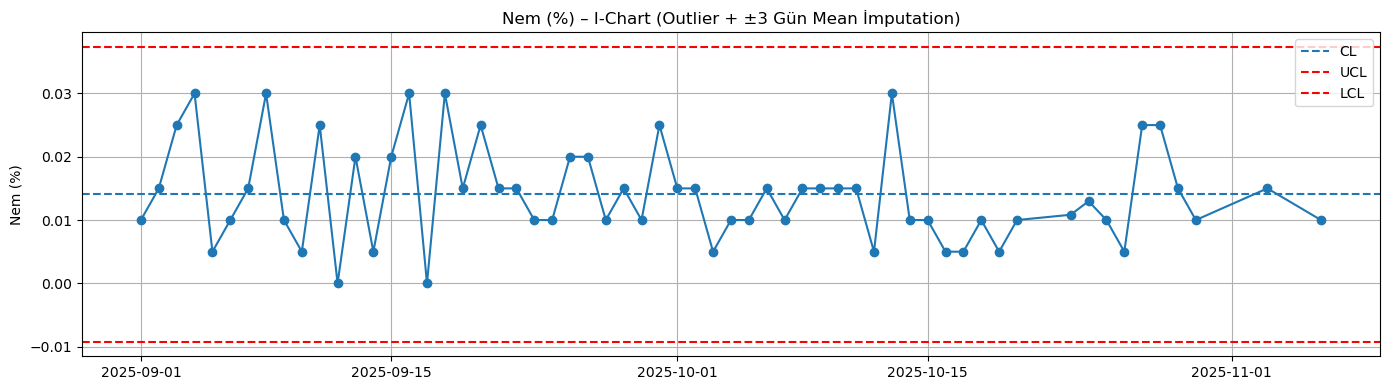

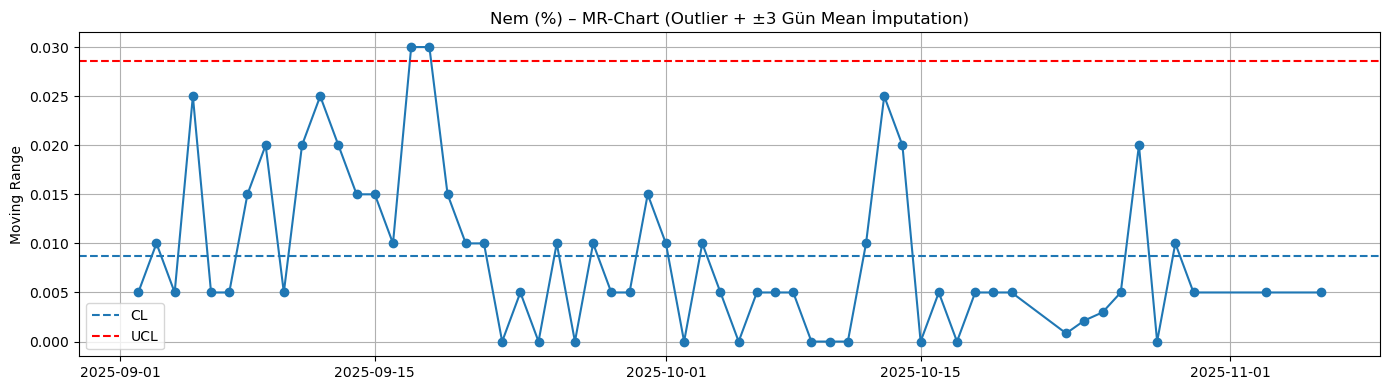

IMPUTE → Mean: 0.0141 Sigma: 0.0078 Cp: 1.5451338563297954 Cpk: 1.5451338563297954

PARAMETRE: Yığın Yoğunluğu (g/cm3)


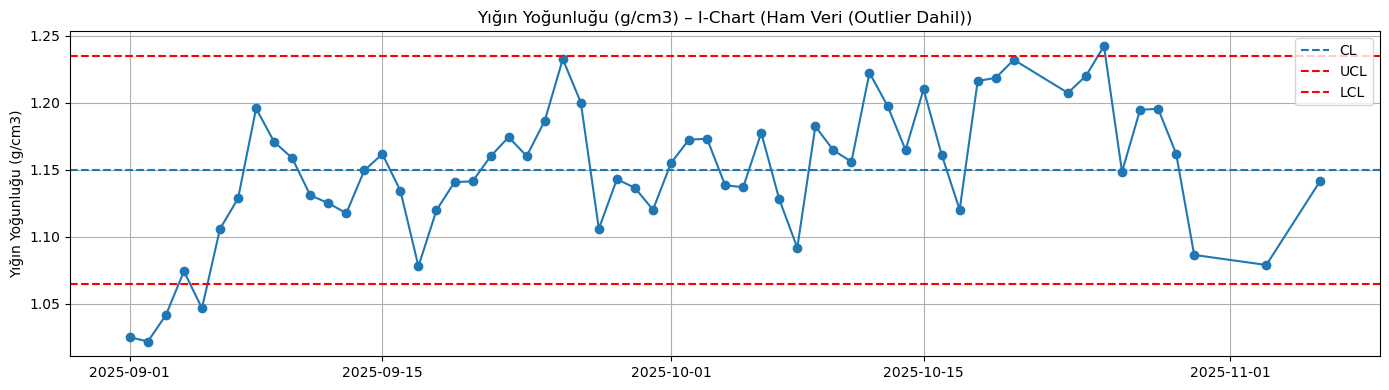

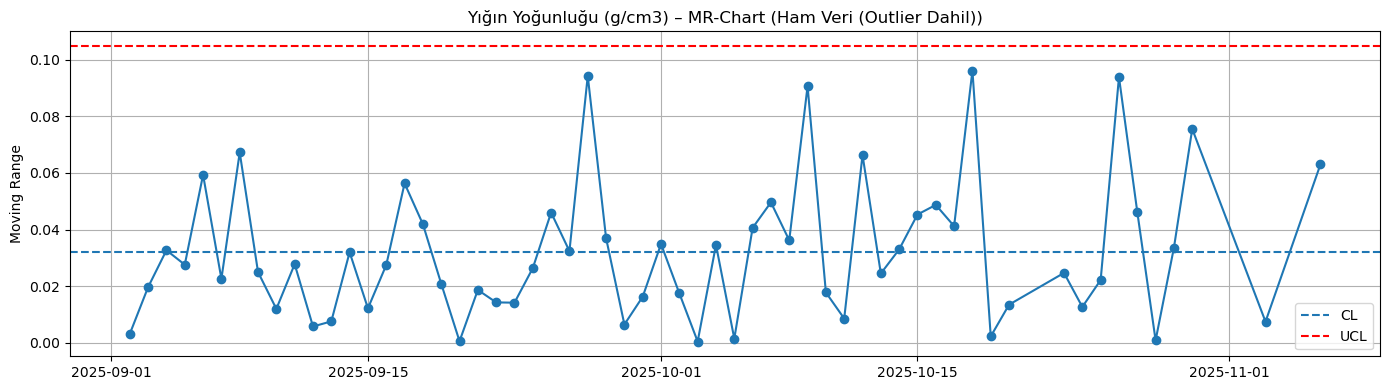

HAM → Mean: 1.1496 Sigma: 0.0284 Cp: 1.1729498228731563 Cpk: 1.1681407285993748


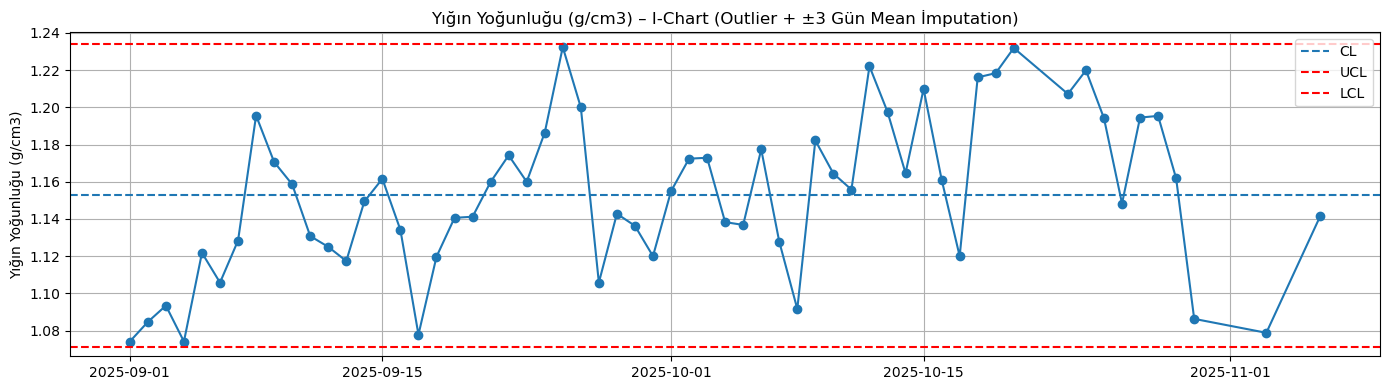

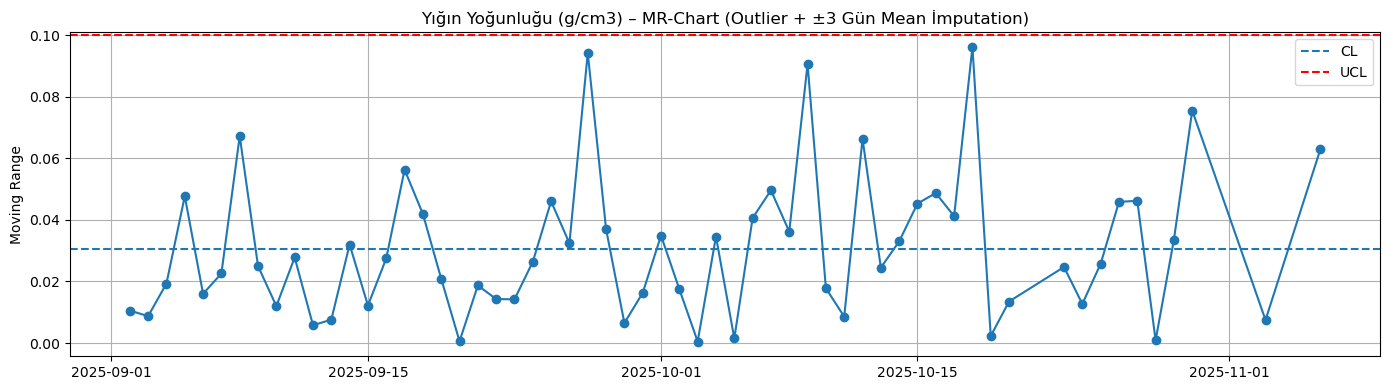

IMPUTE → Mean: 1.1528 Sigma: 0.0271 Cp: 1.2278597849194832 Cpk: 1.1937007257030239


In [66]:
for param, limits in PARAMETERS.items():
    print("\n" + "="*60)
    print("PARAMETRE:", param)
    print("="*60)

    # =====================
    # HAM VERİ
    # =====================
    stats_raw = draw_imr(df, param, "Ham Veri (Outlier Dahil)")
    Cp_raw, Cpk_raw = cp_cpk(
        stats_raw["mean"],
        stats_raw["sigma"],
        LSL=limits.get("LSL"),
        USL=limits.get("USL")
    )

    print("HAM → Mean:", round(stats_raw["mean"],4),
          "Sigma:", round(stats_raw["sigma"],4),
          "Cp:", Cp_raw,
          "Cpk:", Cpk_raw)

    # =====================
    # IMPUTATION SONRASI
    # =====================
    stats_imp = draw_imr(df_imputed, param, "Outlier + ±3 Gün Mean İmputation")
    Cp_imp, Cpk_imp = cp_cpk(
        stats_imp["mean"],
        stats_imp["sigma"],
        LSL=limits.get("LSL"),
        USL=limits.get("USL")
    )

    print("IMPUTE → Mean:", round(stats_imp["mean"],4),
          "Sigma:", round(stats_imp["sigma"],4),
          "Cp:", Cp_imp,
          "Cpk:", Cpk_imp)


yeterlilik

In [67]:
SPECIFICATIONS = {
    "NaHCO3 Ortalama(%)":      {"LSL": 99.3, "USL": None},
    "Na2CO3 Ortalama(%)":      {"LSL": None, "USL": 0.5},
    "Cl- Ortalama(mg/kg)":     {"LSL": None, "USL": 250},
    "SO42- Ortalama(mg/kg)":   {"LSL": None, "USL": 300},
    "SÇM Ortalama(mg/kg)":     {"LSL": None, "USL": 500},
    "S.Nem Ortalama(%)":       {"LSL": 0.0,  "USL": 0.05},
    "Yığın Yoğunluğu Ortalama(g/cm3)": {"LSL": 0.90, "USL": 1.25}
}
def cp_cpk_from_limits(mean, sigma, LSL=None, USL=None):
    if sigma is None or sigma == 0 or np.isnan(sigma):
        return np.nan, np.nan

    if LSL is not None and USL is not None:
        Cp = (USL - LSL) / (6 * sigma)
        Cpk = min(
            (USL - mean) / (3 * sigma),
            (mean - LSL) / (3 * sigma)
        )
    elif USL is not None:
        Cp = (USL - mean) / (3 * sigma)
        Cpk = Cp
    elif LSL is not None:
        Cp = (mean - LSL) / (3 * sigma)
        Cpk = Cp
    else:
        Cp, Cpk = np.nan, np.nan

    return Cp, Cpk


In [68]:
def imr_stats(df, col):
    x = df[col].dropna().values
    MR = np.abs(np.diff(x))
    d2 = 1.128

    mean = np.mean(x)
    sigma = np.mean(MR) / d2 if np.mean(MR) > 0 else np.nan

    return mean, sigma


In [69]:
results = []

for param, spec in PARAMETERS.items():
    mean, sigma = imr_stats(df_imputed, param)

    LSL = spec.get("LSL")
    USL = spec.get("USL")

    if sigma == 0 or np.isnan(sigma):
        Cp = Cpk = np.nan
    else:
        if LSL is not None and USL is not None:
            Cp = (USL - LSL) / (6 * sigma)
            Cpk = min(
                (USL - mean) / (3 * sigma),
                (mean - LSL) / (3 * sigma)
            )
        elif USL is not None:
            Cp = (USL - mean) / (3 * sigma)
            Cpk = Cp
        elif LSL is not None:
            Cp = (mean - LSL) / (3 * sigma)
            Cpk = Cp
        else:
            Cp = Cpk = np.nan

    if np.isnan(Cpk):
        status = "Hesaplanamadı"
    elif Cpk >= 1.33:
        status = "Yeterli"
    elif Cpk >= 1.00:
        status = "Şartlı"
    else:
        status = "Yetersiz"

    results.append({
        "Parametre": param,
        "Mean (CL)": round(mean, 5),
        "Sigma (I-MR)": round(sigma, 5),
        "LSL": LSL,
        "USL": USL,
        "Cp": None if np.isnan(Cp) else round(Cp, 3),
        "Cpk": None if np.isnan(Cpk) else round(Cpk, 3),
        "Durum": status
    })

results_df = pd.DataFrame(results)
display(results_df)


,Parametre,Mean (CL),Sigma (I-MR),LSL,USL,Cp,Cpk,Durum
0,NaHCO3 (%),99.74047,0.04456,99.60,99.90,1.122,1.051,Şartlı
1,Na2CO3 (%),0.11786,0.02827,0.08,0.15,0.413,0.379,Yetersiz
2,Cl- (mg/kg),126.30460,22.88989,NaN,200.00,1.073,1.073,Şartlı
3,SO42-(mg/kg),182.72140,38.58730,NaN,300.00,1.013,1.013,Şartlı
4,SÇM (mg/kg),256.43195,28.79783,NaN,600.00,3.977,3.977,Yeterli
5,Nem (%),0.01406,0.00775,NaN,0.05,1.545,1.545,Yeterli
6,Yığın Yoğunluğu (g/cm3),1.15278,0.02715,1.05,1.25,1.228,1.194,Şartlı


In [70]:
def has_trend(series, window=14, thresh=0.05):
    if len(series) < window + 2:
        return False

    y = series[-window:].values
    x = np.arange(len(y))

    slope = np.polyfit(x, y, 1)[0]
    return abs(slope) > thresh * np.std(y)


In [71]:
def fit_spc_forecast(series):
    # Trend testi
    trend_flag = has_trend(series)

    candidates = {}

    if trend_flag:
        candidates = {
            "HOLT": ExponentialSmoothing(series, trend="add"),
            "DAMPED": ExponentialSmoothing(series, trend="add", damped_trend=True)
        }
    else:
        candidates = {
            "SES": ExponentialSmoothing(series, trend=None),
            "DAMPED": ExponentialSmoothing(series, trend="add", damped_trend=True)
        }

    best_aic = np.inf
    best_fit = None
    best_name = None

    for name, model in candidates.items():
        try:
            fit = model.fit(optimized=True)
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_fit = fit
                best_name = name
        except:
            continue

    return best_fit, best_name


/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                               SARIMAX Results                                
Dep. Variable:            SÇM (mg/kg)   No. Observations:                   57
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -274.947
Date:                Sat, 10 Jan 2026   AIC                            561.894
Time:                        20:09:18   BIC                            573.938
Sample:                             0   HQIC                           566.552
                                 - 57                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

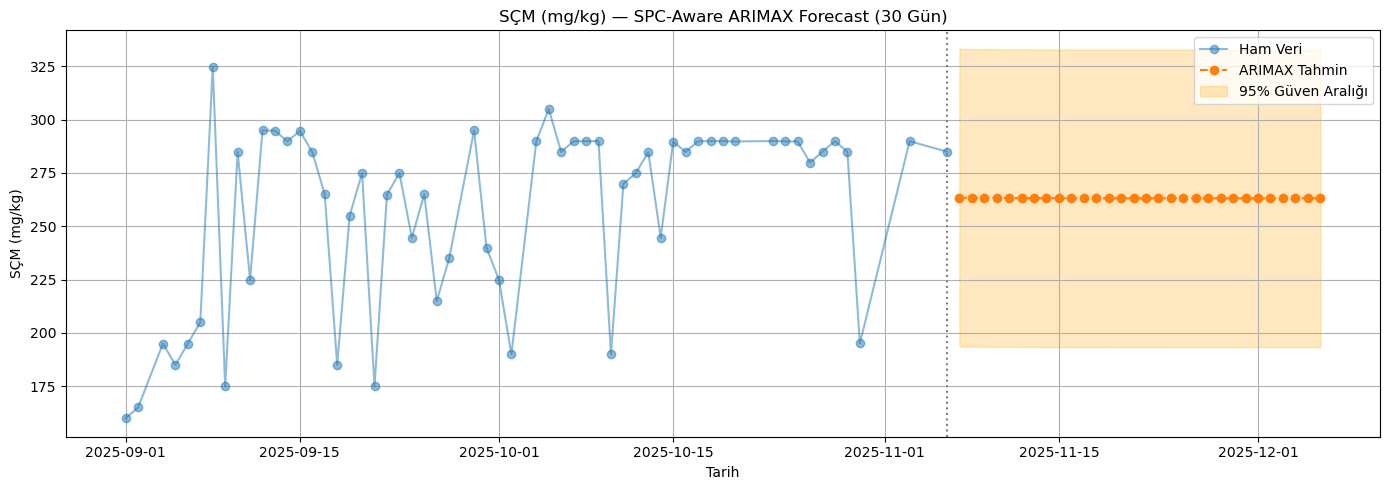

,Tahmin,Alt %95,Üst %95
2025-11-07,263.431369,193.613453,333.249286
2025-11-08,263.341280,193.520968,333.161592
2025-11-09,263.274300,193.452664,333.095936
2025-11-10,263.224500,193.402132,333.046868
2025-11-11,263.187475,193.364703,333.010248
2025-11-12,263.159947,193.336951,332.982943
2025-11-13,263.139480,193.316361,332.962600
2025-11-14,263.124264,193.301076,332.947452
2025-11-15,263.112950,193.289724,332.936176
2025-11-16,263.104539,193.281292,332.927785


In [72]:
# =====================================================
# SPC-AWARE ARIMAX — SÇM (mg/kg)
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -----------------------------------------------------
# 1️⃣ VERİ HAZIRLIĞI (HAM VERİ)
# -----------------------------------------------------
df_arimax = df.copy()
df_arimax = df_arimax.sort_values("Datetime")
df_arimax = df_arimax.set_index("Datetime")

TARGET = "SÇM (mg/kg)"
EXOG = ["Nem (%)", "Yığın Yoğunluğu (g/cm3)"]

# -----------------------------------------------------
# 2️⃣ SPC OUTLIER MASK (SADECE TARGET İÇİN)
# -----------------------------------------------------
def spc_outlier_mask(series):
    x = series.dropna().values
    if len(x) < 5:
        return pd.Series(False, index=series.index)

    MR = np.abs(np.diff(x))
    d2 = 1.128
    sigma = np.mean(MR) / d2 if np.mean(MR) > 0 else 0
    mean = np.mean(x)

    UCL = mean + 3 * sigma
    LCL = mean - 3 * sigma

    return (series < LCL) | (series > UCL)

mask = spc_outlier_mask(df_arimax[TARGET])

# outlier’ları DROP et (impute YOK)
df_arimax.loc[mask, TARGET] = np.nan
df_arimax = df_arimax.dropna(subset=[TARGET] + EXOG)

# -----------------------------------------------------
# 3️⃣ MODEL VERİSİ
# -----------------------------------------------------
y = df_arimax[TARGET]
X = df_arimax[EXOG]

# -----------------------------------------------------
# 4️⃣ ARIMAX MODEL (kısa seri için stabil)
# -----------------------------------------------------
model = SARIMAX(
    y,
    exog=X,
    order=(1, 0, 1),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
)

fit = model.fit(disp=False)
print(fit.summary())

# -----------------------------------------------------
# 5️⃣ 30 GÜNLÜK FORECAST (INDEX FIXLİ)
# -----------------------------------------------------
HORIZON = 30

forecast_index = pd.date_range(
    start=y.index.max() + pd.Timedelta(days=1),
    periods=HORIZON,
    freq="D"
)

# Exog ileri taşıma: son değerleri sabit tut
X_future = pd.DataFrame(
    np.tile(X.iloc[-1].values, (HORIZON, 1)),
    columns=EXOG,
    index=forecast_index
)

forecast_obj = fit.get_forecast(steps=HORIZON, exog=X_future)

forecast_mean = pd.Series(
    forecast_obj.predicted_mean.values,
    index=forecast_index
)

conf_int = forecast_obj.conf_int()
conf_int.index = forecast_index

# -----------------------------------------------------
# 6️⃣ GRAFİK
# -----------------------------------------------------
plt.figure(figsize=(14,5))

plt.plot(
    y.index,
    y,
    marker="o",
    alpha=0.5,
    label="Ham Veri"
)

plt.plot(
    forecast_mean.index,
    forecast_mean,
    linestyle="--",
    marker="o",
    label="ARIMAX Tahmin"
)

plt.fill_between(
    forecast_mean.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color="orange",
    alpha=0.25,
    label="95% Güven Aralığı"
)

plt.axvline(y.index.max(), color="gray", linestyle=":")

plt.title("SÇM (mg/kg) — SPC-Aware ARIMAX Forecast (30 Gün)")
plt.ylabel("SÇM (mg/kg)")
plt.xlabel("Tarih")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 7️⃣ TAHMİN TABLOSU
# -----------------------------------------------------
forecast_df = pd.DataFrame({
    "Tahmin": forecast_mean,
    "Alt %95": conf_int.iloc[:, 0],
    "Üst %95": conf_int.iloc[:, 1]
})

display(forecast_df.head(10))


In [73]:
import pandas as pd
import xgboost

print("pandas:", pd.__version__)
print("xgboost:", xgboost.__version__)


pandas: 2.0.3
xgboost: 1.5.0


In [74]:
fghjklş

NameError: name 'fghjklş' is not defined

In [13]:
def spc_outlier_mask(series):
    x = series.dropna().values
    MR = np.abs(np.diff(x))
    d2 = 1.128

    mean = np.mean(x)
    sigma = np.mean(MR) / d2 if np.mean(MR) > 0 else 0

    UCL = mean + 3 * sigma
    LCL = mean - 3 * sigma

    return (series < LCL) | (series > UCL)


In [14]:
def prepare_forecast_series(df, col):
    mask = spc_outlier_mask(df[col])
    clean_series = df.loc[~mask, col]
    return clean_series.dropna()


In [15]:
df_spc = df_imputed.copy()
df_fc = df.copy()

mask = spc_outlier_mask(df_fc[col])
df_fc.loc[mask, col] = np.nan   # sadece drop
series = df_fc[col].dropna()


In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def fit_best_ets(series):
    models = {
        "SES": ExponentialSmoothing(series, trend=None),
        "HOLT": ExponentialSmoothing(series, trend="add"),
        "DAMPED": ExponentialSmoothing(series, trend="add", damped_trend=True)
    }

    best_aic = np.inf
    best_model = None
    best_name = None

    for name, model in models.items():
        try:
            fit = model.fit(optimized=True)
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_model = fit
                best_name = name
        except:
            continue

    return best_model, best_name


In [17]:
HORIZON = 30
forecast_results = {}

for col in FORECAST_COLS:
    series = prepare_forecast_series(df_fc, col)

    if len(series) < 15:
        print(f"⚠️ {col}: Yetersiz veri")
        continue

    model, model_name = fit_best_ets(series)
    forecast = model.forecast(HORIZON)

    forecast_results[col] = {
        "model": model_name,
        "forecast": forecast
    }


/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base

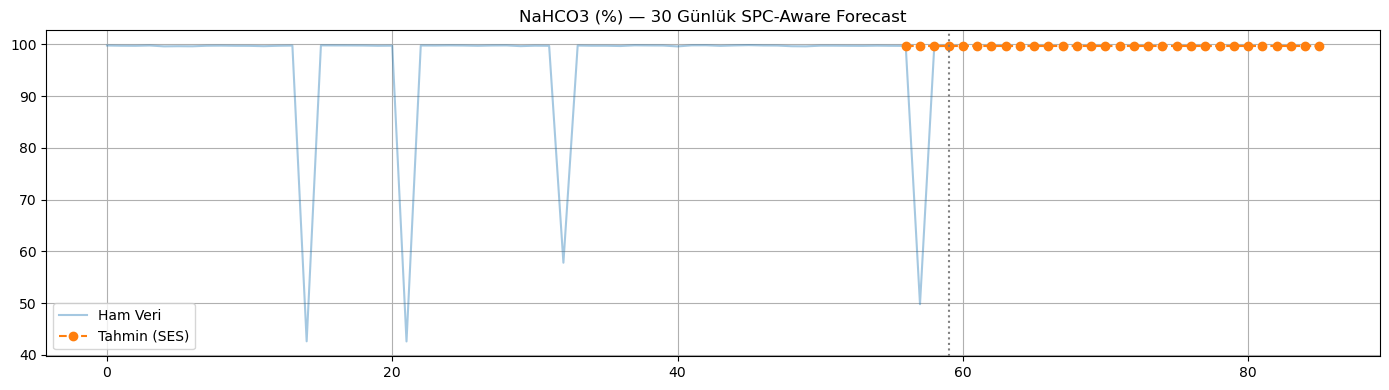

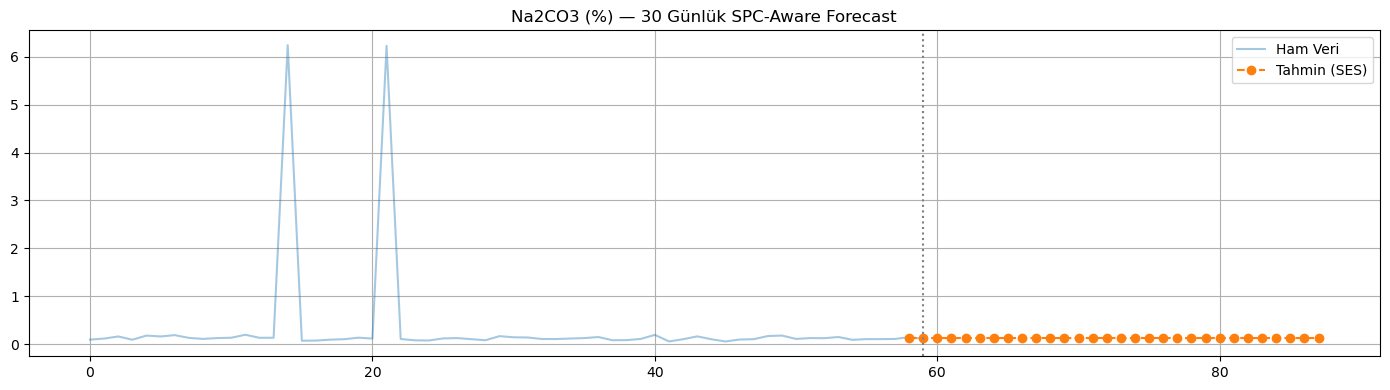

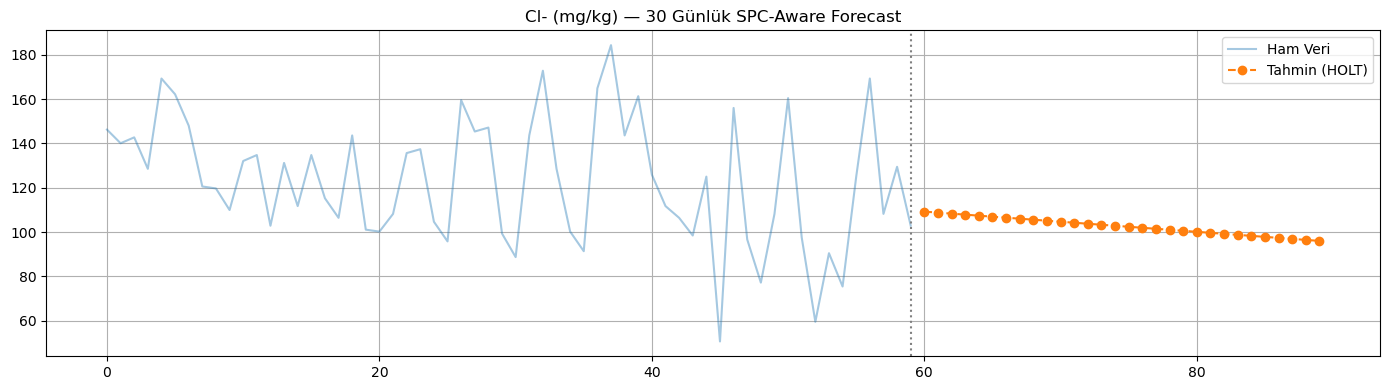

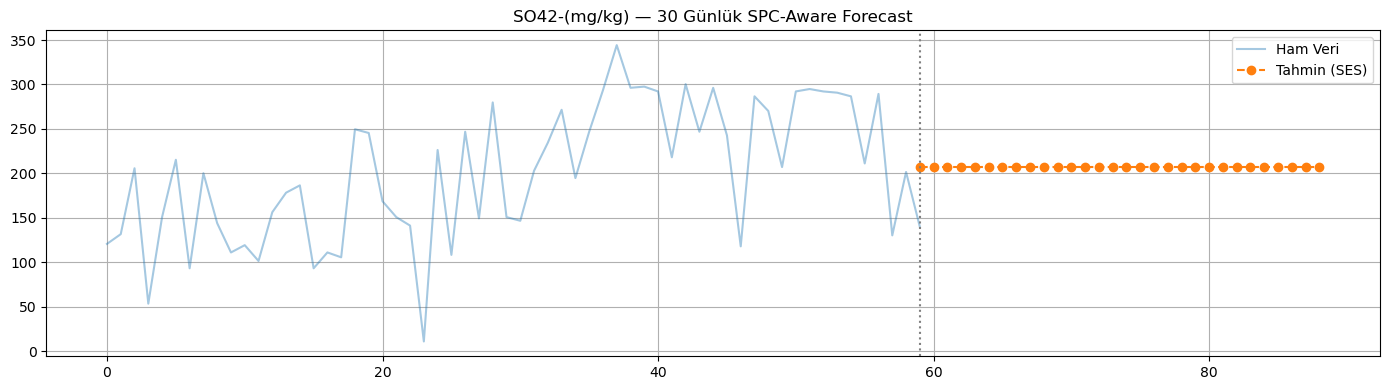

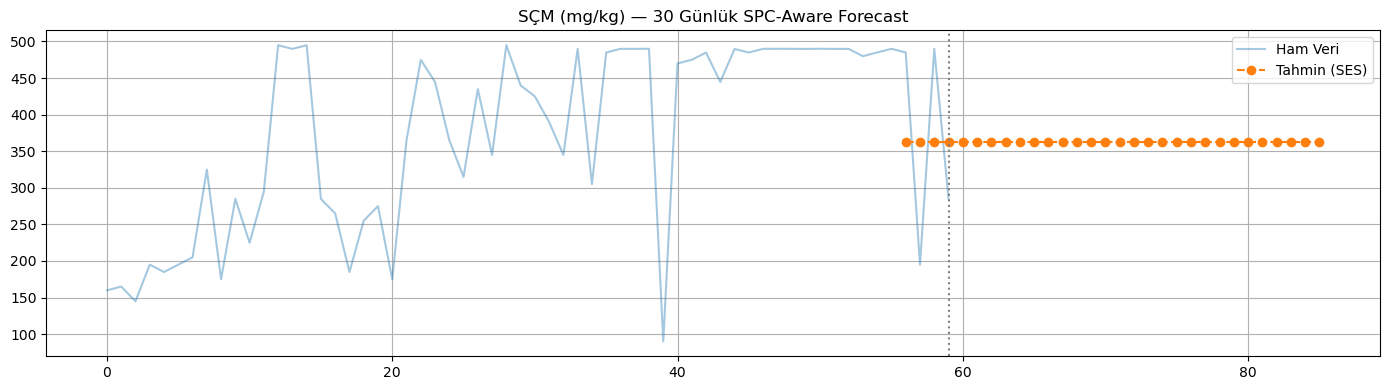

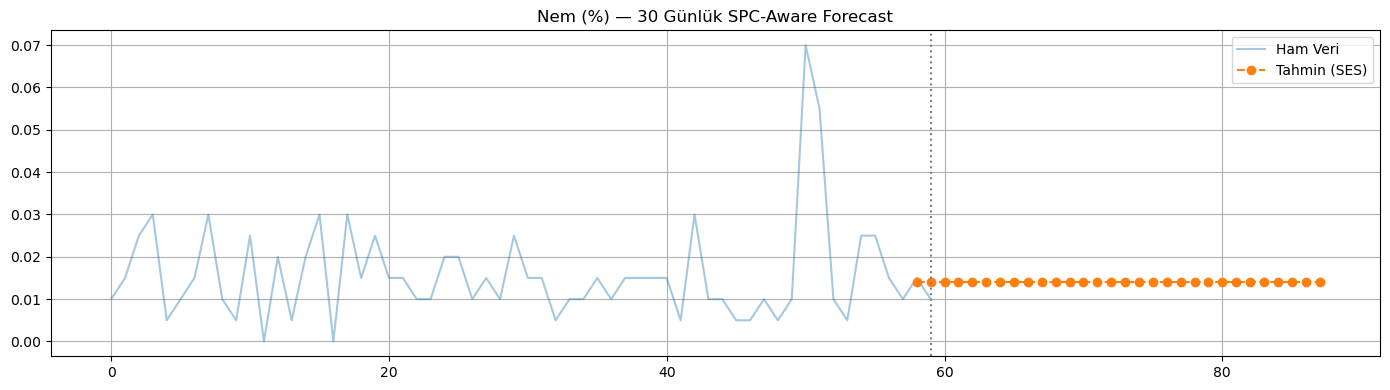

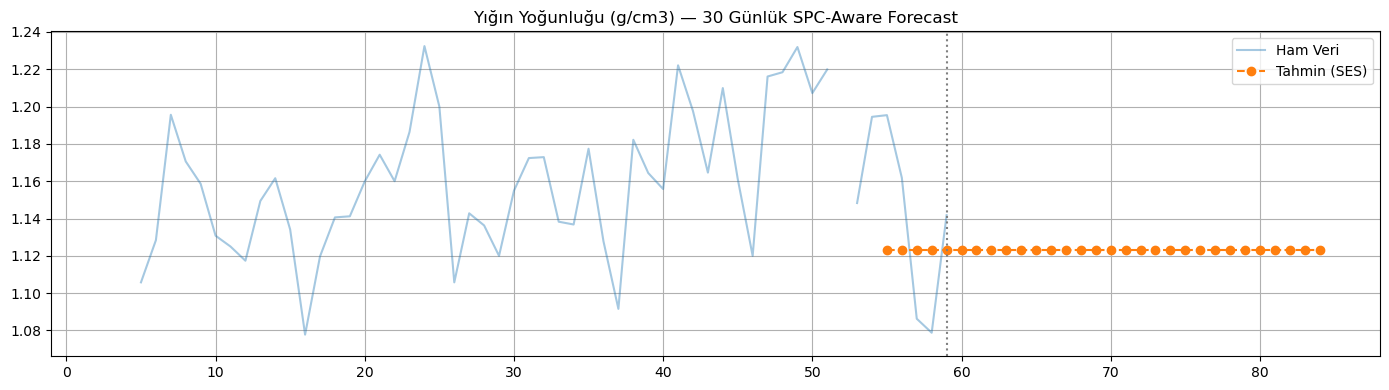

In [18]:
for col, res in forecast_results.items():
    plt.figure(figsize=(14,4))

    plt.plot(df_fc.index, df_fc[col], alpha=0.4, label="Ham Veri")
    plt.plot(res["forecast"].index, res["forecast"],
             linestyle="--", marker="o", label=f"Tahmin ({res['model']})")

    plt.axvline(df_fc.index.max(), color="gray", linestyle=":")
    plt.title(f"{col} — 30 Günlük SPC-Aware Forecast")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
